# Customer Conversion Predictor


## Customer Conversion Predictor – Intelligent Targeting

### Marketing Overview
Marketing focuses on delivering value to customers while driving business outcomes. Effective campaigns depend on understanding customer needs and targeting the right audience with the right message.

However, not all customers respond equally. Identifying high-probability converters before launching a campaign is critical for maximizing impact and minimizing cost.

---

### Core Campaign Dimensions

1. **Target Audience**  
   Identifying customers most likely to convert allows campaigns to be focused, personalized, and cost-efficient.

2. **Distribution Channels**  
   Channels such as phone, email, or digital outreach should align with customer behavior and past engagement patterns.

3. **Value Proposition**  
   In financial campaigns, success depends less on pricing and more on clearly communicating value and relevance to the customer.

4. **Promotional Strategy**  
   Campaign messaging should be informed by historical performance data to reinforce what works and avoid ineffective outreach.

---

### Key Considerations
- **Data-Driven Targeting**: Use customer data to segment and prioritize high-conversion prospects.  
- **Continuous Optimization**: Evaluate campaign outcomes and refine targeting strategies over time.  
- **Regulatory Compliance**: Ensure all outreach adheres to data privacy and industry regulations.


## A. Attributes Description

### Input Variables

#### A.i. Bank Client Data
1. **age** – Age of the client *(numeric)*  
2. **job** – Type of job  
   *(categorical: 'admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown')*  
3. **marital** – Marital status  
   *(categorical: 'divorced', 'married', 'single', 'unknown'; note: 'divorced' includes divorced and widowed)*  
4. **education** – Level of education  
   *(categorical: 'primary', 'secondary', 'tertiary', 'unknown')*  
5. **default** – Has credit in default?  
   *(categorical: 'no', 'yes', 'unknown')*  
6. **housing** – Has a housing loan?  
   *(categorical: 'no', 'yes', 'unknown')*  
7. **loan** – Has a personal loan?  
   *(categorical: 'no', 'yes', 'unknown')*  
8. **balance** – Average yearly account balance of the client *(numeric)*  

---

#### A.ii. Related to the Last Contact in the Current Campaign
9. **contact** – Communication type used to contact the client  
   *(categorical: 'cellular', 'telephone')*  
10. **month** – Last contact month  
    *(categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')*  
11. **day** – Last contact day of the week  
    *(categorical: 'mon', 'tue', 'wed', 'thu', 'fri')*  
12. **duration** – Last contact duration in seconds *(numeric)*  
    > **Important:** Duration has a strong influence on the output. If `duration = 0`, the outcome is almost always `'no'`.  
    > However, since this is only known **after** the contact, it should not be used for building a predictive model meant for real-world deployment. It is typically included for benchmarking purposes only.

---

#### A.iii. Other Attributes
13. **campaign** – Number of contacts performed during this campaign for this client (includes last contact) *(numeric)*  
14. **pdays** – Number of days since the client was last contacted in a previous campaign *(numeric; 999 means not previously contacted)*  
15. **previous** – Number of contacts performed before this campaign for this client *(numeric)*  
16. **poutcome** – Outcome of the previous marketing campaign  
    *(categorical: 'failure', 'nonexistent', 'success')*  

---

### Output Variable (Target)
- **y** – Has the client subscribed to a term deposit? *(binary: 'yes', 'no')*


In [148]:
%pip install scikit-learn seaborn plotly xgboost

Note: you may need to restart the kernel to use updated packages.


In [149]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
import plotly.figure_factory as ff
import matplotlib.image as mpimg

import time
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [150]:
dataframe = pd.read_csv('bank data.csv')
df = dataframe.copy()
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


<span style="font-size:17px">We can see that there are no missing values in the dataframe. If there were, we would have to impute them.</span>


In [152]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000



**Summary:**

- **Time since last campaign:** Average time since contacts were previously called was a long time ago, so this campaign makes sense to do.
- **Mean Age:** Approximately 41 years old   
- **Mean Balance:** 1,528. However, the Standard Deviation (std) is high, indicating that the balance is heavily distributed across the dataset.  
- **Duration Column:** It is better to drop this column since duration is highly correlated with whether a potential client will buy a term deposit. Duration is obtained after the call is made to the potential client, so if the target client has never received calls, this feature is not very useful. The correlation exists because the more the bank talks to a target client, the higher the probability they will open a term deposit—longer duration often indicates higher interest or commitment from the potential client.


[Text(0, 0.5, '(%)')]

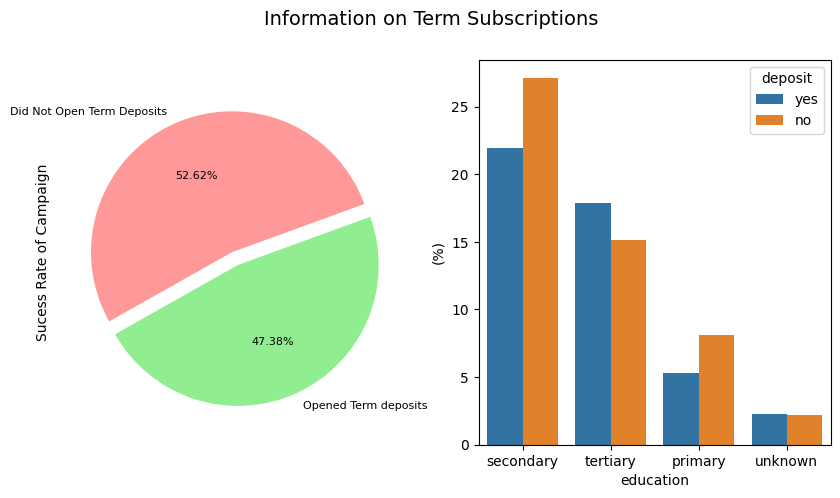

In [153]:
labels = ["Did Not Open Term Deposits", "Opened Term deposits"]
colours = ["#FF9999", "#90EE90"]  
figure, ax = plt.subplots(1,2, figsize = (10, 5))
plt.suptitle("Information on Term Subscriptions", fontsize= 14)
df['deposit'].value_counts().plot.pie(
    colors=colours,
    labels=labels, 
    fontsize = 8, 
    autopct='%.2f%%', 
    explode=[0, 0.1],
    startangle=20,
    ax=ax[0])
ax[0].set_ylabel("Sucess Rate of Campaign")
sns.barplot(x="education", y="balance", hue="deposit", data=df, estimator=lambda x:len(x) / len(df) * 100)
ax[1].set(ylabel="(%)")


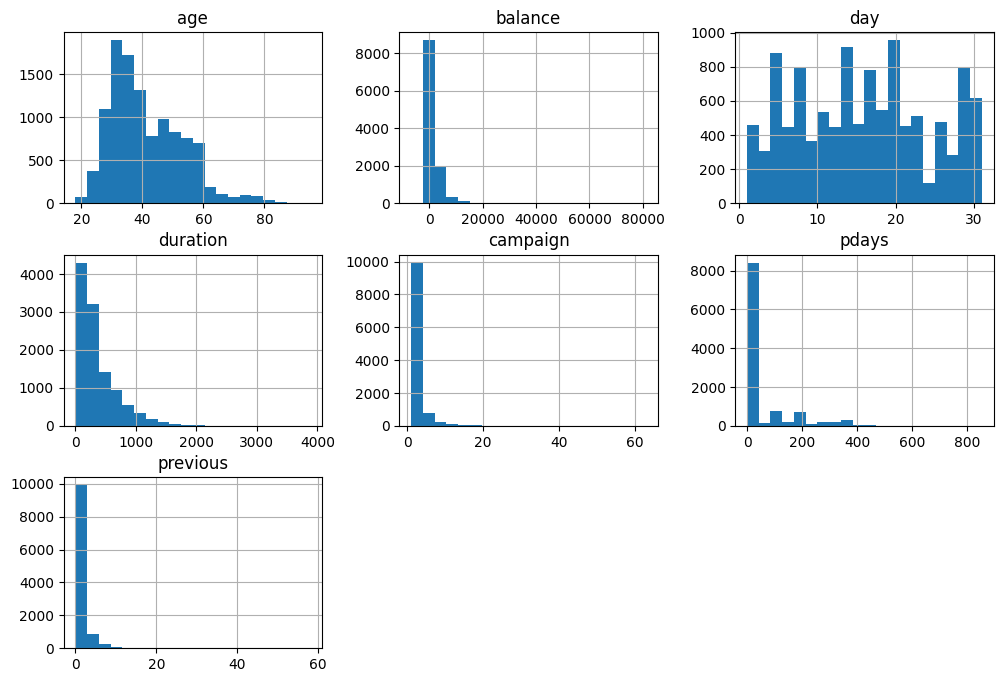

In [154]:
import matplotlib.pyplot as plt
df.hist(bins=20, figsize=(12, 8))
plt.show()

In [155]:
df['deposit'].value_counts()

deposit
no     5873
yes    5289
Name: count, dtype: int64

<Axes: xlabel='marital', ylabel='count'>

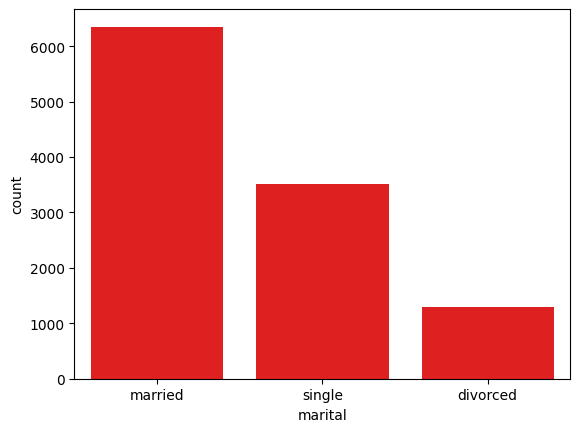

In [156]:
sns.barplot(data=df['marital'].value_counts(), color='red')

### Key Clustering Insights:  
- **Marital Status:** Divorce significantly impacts balance.  
- **Education:** Higher education correlates with higher balances.  
- **Loans:** Existing loans influence balance distribution.  

In [157]:
df['marital'].value_counts()

marital
married     6351
single      3518
divorced    1293
Name: count, dtype: int64

In [158]:
df = df.drop(df[df['education'] == 'unknown'].index)
df['education'].value_counts()

education
secondary    5476
tertiary     3689
primary      1500
Name: count, dtype: int64

In [159]:
df['marital/education'] = np.nan
df.loc[(df['marital'] == 'single') & (df['education'] == 'primary'), 'marital/education'] = 'single/primary'
df.loc[(df['marital'] == 'single') & (df['education'] == 'tertiary'), 'marital/education'] = 'single/tertiary'
df.loc[(df['marital'] == 'single') & (df['education'] == 'secondary'), 'marital/education'] = 'single/secondary'

df.loc[(df['marital'] == 'married') & (df['education'] == 'primary'), 'marital/education'] = 'married/primary'
df.loc[(df['marital'] == 'married') & (df['education'] == 'tertiary'), 'marital/education'] = 'married/tertiary'
df.loc[(df['marital'] == 'married') & (df['education'] == 'secondary'), 'marital/education'] = 'married/secondary'

df.loc[(df['marital'] == 'divorced') & (df['education'] == 'primary'), 'marital/education'] = 'divorced/primary'
df.loc[(df['marital'] == 'divorced') & (df['education'] == 'tertiary'), 'marital/education'] = 'divorced/tertiary'
df.loc[(df['marital'] == 'divorced') & (df['education'] == 'secondary'), 'marital/education'] = 'divorced/secondary'

C:\Users\Shervin Zare\AppData\Local\Temp\ipykernel_6496\3488568193.py:2: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'single/primary' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



C:\Users\Shervin Zare\AppData\Local\Temp\ipykernel_6496\1673451804.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




Text(0, 0.5, 'Marital Status/Education')

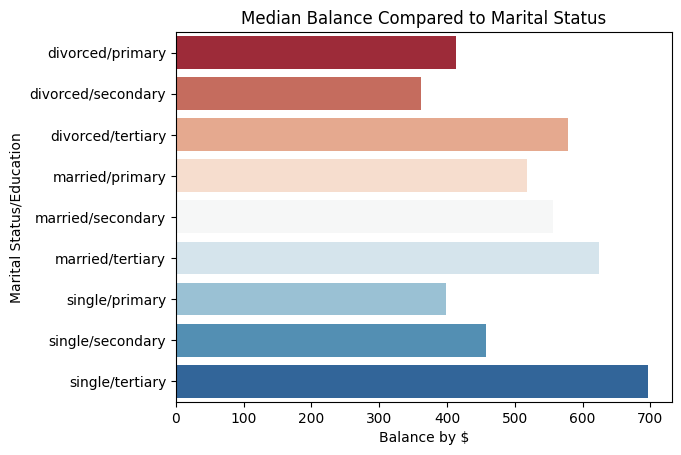

In [160]:
education_groups = df.groupby(['marital/education'], as_index=False)['balance'].median()
ax = sns.barplot(y='marital/education', x='balance', data=education_groups, palette="RdBu")
plt.title('Median Balance Compared to Marital Status')
ax.set_xlabel('Balance by $')
ax.set_ylabel('Marital Status/Education')

## Campaign Duration

We see that **duration** has a high correlation with term deposits, meaning the higher the duration, the more likely it is for a client to open a term deposit.  

**Average Campaign Duration:** The average campaign duration is **374.76**. Let's see if clients above this average were more likely to open a term deposit.  

**Duration Status:** People who were above the average duration were more likely to open a term deposit. **78%** of the group above average in duration opened term deposits, while only **32%** of those below average did.  

This suggests it would be a good strategy to target individuals in the above-average duration category.


Text(0.5, 1.0, 'Correlation Matrix ')

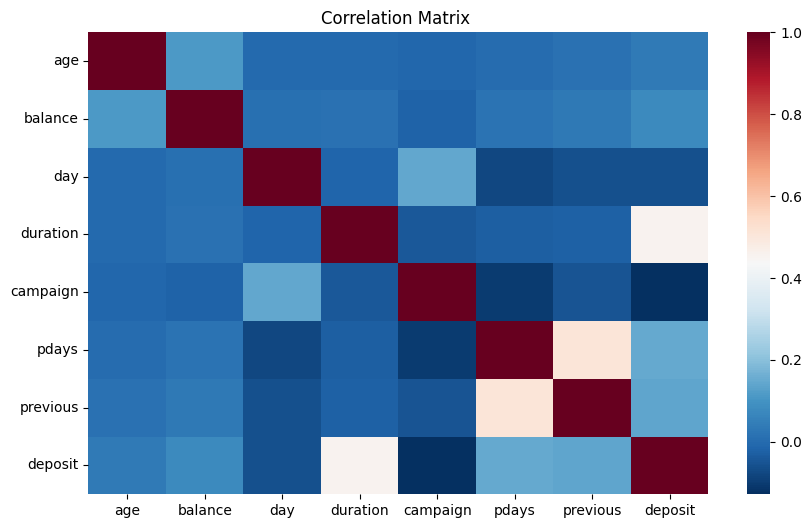

In [161]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

df.drop(['marital/education', 'balance'], axis=1)
df['deposit'] = LabelEncoder().fit_transform(df['deposit'])

numeric_df = df.select_dtypes(exclude="object")
corr_numeric = numeric_df.corr()

fig = plt.figure(figsize=(10,6))
sns.heatmap(corr_numeric, cbar=True, cmap="RdBu_r")
plt.title("Correlation Matrix ")

In [162]:
df['dur_bin'] = np.nan
df.loc[df['duration'] <= 485.125, 'dur_bin'] = '(0 - 485)'
df.loc[(df['duration'] > 485.125) & (df['duration'] <= 3881), 'dur_bin'] = '(485 - 3881)'

C:\Users\Shervin Zare\AppData\Local\Temp\ipykernel_6496\34697197.py:2: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '(0 - 485)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



Text(0.5, 1.0, 'Subscription Outcomes By Call Duration')

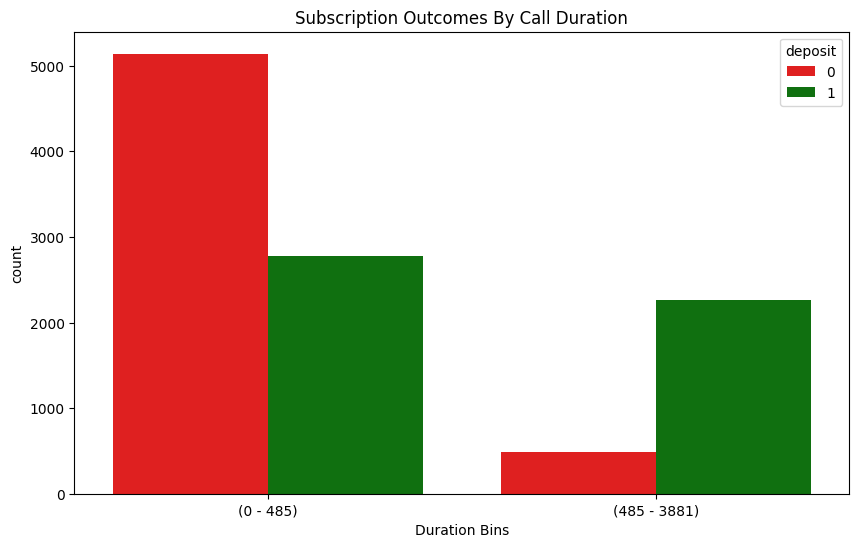

In [163]:
fig = plt.figure(figsize=(10,6))
dur_counts = df.groupby(by=['deposit', 'dur_bin']).size().reset_index(name='count')
sns.barplot(x="dur_bin", y="count", data=dur_counts, hue="deposit", palette=['red', 'green'])
plt.xlabel("Duration Bins")
plt.title("Subscription Outcomes By Call Duration")

## Stratified Sampling  

Stratified sampling ensures that the target variable (`deposit`) is represented in the training and test sets with the **same proportion** as in the full dataset. This prevents bias in the split and helps the model generalize better, especially when the classes are imbalanced.  

In our case, the `deposit` column is the label we want to predict, and its distribution (majority `no`, minority `yes`) must be preserved across both training and testing.  

### How We Applied It  
Using `train_test_split` with the `stratify` parameter, we tell scikit-learn to split the dataset while maintaining the same ratio of `deposit = yes` and `deposit = no` in both sets:  

1. Define `x` as the features and `y` as the target (`deposit`).  
2. Call `train_test_split` with `stratify=y` to enforce proportional distribution.  
3. The training and test sets now reflect the real-world class balance, reducing sampling bias and improving reliability of evaluation metrics.  

This approach makes sure the model learns from a balanced representation of the target variable, avoiding skewed results that could come from random splits.  

In [164]:
from sklearn.model_selection import train_test_split

x = dataframe.drop(columns=['deposit'], axis=1)
y= dataframe['deposit']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, stratify=y, random_state=42)


y_test.head()

8220     no
2521    yes
7949     no
7879     no
616     yes
Name: deposit, dtype: object

## Feature Engineering & Data Preprocessing  

Before training machine learning models, it’s essential to **prepare the data** so that the algorithms can efficiently learn patterns. Here’s how we handled preprocessing for our term deposit dataset:

### 1. Numerical Features  
Columns like `age`, `balance`, `duration`, etc., were **standardized** using `StandardScaler`. This ensures all numeric features are on the same scale, which helps models converge faster and perform better.

### 2. Categorical Features  
Columns such as `job`, `marital`, `education`, and `loan` were **one-hot encoded** using `OneHotEncoder`. This converts categorical variables into a machine-readable format while safely handling unknown categories in the test set.

### 3. Label Encoding  
The target variable `deposit` was **encoded** from string labels (`yes`/`no`) to numeric labels (`1`/`0`) using `LabelEncoder`, making it suitable for supervised classification.


This systematic preprocessing ensures that our models are fed **clean, scaled, and consistent data**, demonstrating skills in feature engineering, pipeline design, and data readiness for machine learning.


In [165]:
numeric_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
categorical_columns = ['job', 'marital', 'education', 'contact', 'default', 'housing', 'loan', 'poutcome']

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_columns),
    ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_columns)
])

x_train_prepared = preprocessor.fit_transform(x_train)
x_test_prepared = preprocessor.transform(x_test)


In [166]:
label_encoder = LabelEncoder()

y_train_prepared = label_encoder.fit_transform(y_train)
y_test_prepared = label_encoder.transform(y_test)

In [167]:
print(f"x_train shape is {x_train_prepared.shape}")
print(f"y_train shape is {y_train_prepared.shape}")
print(f"x_test shape is {x_test_prepared.shape}")
print(f"y_test shape is {y_test_prepared.shape}")

x_train shape is (8929, 39)
y_train shape is (8929,)
x_test shape is (2233, 39)
y_test shape is (2233,)


## Benchmarking Multiple Classifiers  

To evaluate the performance of different machine learning algorithms on our dataset, we systematically **trained and compared several classifiers** using the preprocessed data.  

### Key Highlights

- **Classifiers Tested:** Neural Net, Logistic Regression, Naive Bayes, Decision Tree, Gradient Boosting, Linear SVM, K-Nearest Neighbors, and XGBoost.  
- **Metrics Collected:** Training accuracy on the full training set and training time, providing insight into both effectiveness and computational efficiency.  
- **Observations:**  
  - Tree-based models like **Decision Tree** achieved very high training scores, reflecting strong fit to the training data.  
  - **XGBoost** offered a strong balance between accuracy and speed, showcasing its power for structured data tasks.  
  - Simpler models like **Logistic Regression** and **Naive Bayes** trained extremely quickly, highlighting efficiency but lower fit on complex patterns.  
  - Neural networks and SVMs showed moderate accuracy with longer training times, demonstrating the trade-off between model complexity and computational cost.  

This benchmarking demonstrates your ability to **systematically compare algorithms, evaluate model efficiency, and choose the right balance between accuracy and performance** — a crucial skill in real-world machine learning projects.



In [168]:
classifier_dict = {
    "Neural Net": MLPClassifier(alpha=1),
    "Logistic Regression": LogisticRegression(),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "Linear SVM": SVC(),
    "Nearest Neighbors": KNeighborsClassifier(), 
    "XGBoost": XGBClassifier() 
}

In [169]:
no_classifiers = len(classifier_dict.keys())

def multiple_classifiy(x_input, y_input, verbose = True):
    results = pd.DataFrame(np.zeros((no_classifiers, 3)),
             columns = ['classifier', 'train_score', 'training_time (s)'])
    count = 0
    for key, classifier in classifier_dict.items():
        t_start = time.perf_counter()
        classifier.fit(x_input, y_input)
        t_end = time.perf_counter()
        t_diff = t_end - t_start
        train_score = classifier.score(x_input, y_input)
        results.loc[count, 'classifier'] = key 
        results.loc[count, 'train_score'] = train_score
        results.loc[count, 'training_time'] = t_diff
        if verbose: 
            print(f"Trained {key} in {t_diff:.2f} s")
        count += 1
    return results

In [170]:
df_results = multiple_classifiy(x_train_prepared, y_train_prepared)
df_results = df_results.sort_values(by='train_score', ascending=False)
df_results


C:\Users\Shervin Zare\AppData\Local\Temp\ipykernel_6496\1853650500.py:13: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Neural Net' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



Trained Neural Net in 7.13 s
Trained Logistic Regression in 0.08 s
Trained Naive Bayes in 0.01 s
Trained Decision Tree in 0.16 s
Trained Gradient Boosting Classifier in 3.87 s
Trained Linear SVM in 4.45 s
Trained Nearest Neighbors in 0.00 s
Trained XGBoost in 0.77 s


,classifier,train_score,training_time (s),training_time
3,Decision Tree,1.000000,0.0,0.162047
7,XGBoost,0.942211,0.0,0.765468
6,Nearest Neighbors,0.843096,0.0,0.002298
5,Linear SVM,0.839624,0.0,4.445908
4,Gradient Boosting Classifier,0.839512,0.0,3.871767
0,Neural Net,0.824952,0.0,7.134743
1,Logistic Regression,0.808041,0.0,0.082930
2,Naive Bayes,0.723261,0.0,0.013481


### ⚠️ Avoiding Overfitting & Optimizing with Cross-Validation

**What is Overfitting?**
Overfitting occurs when a model learns random noise and specific details from the training data rather than the underlying pattern. This leads to excellent performance on the training set but poor performance on unseen test data. In our benchmark, the Decision Tree classifier showed signs of overfitting with nearly perfect training scores (~100% and 99%), indicating they memorized the data instead of learning generalizable patterns.

**How We Avoid Overfitting and Improve Accuracy**
We use **cross-validation** during hyperparameter tuning with GridSearchCV. Here's how it works:
- The training data is split into 3 folds ( StratifiedKFold with n_splits=3)
- For each hyperparameter combination, the model is trained on 2 folds (66% of data) and validated on the remaining 1 fold (33%)
- This process repeats 3 times, with each fold serving as the validation set once
- The average performance across all folds determines the best parameters

This approach ensures the model learns the overall pattern of the data rather than memorizing noise. By testing multiple parameter combinations through **GridSearchCV**, we optimize each model's configuration to maximize generalization and accuracy on unseen data, resulting in more reliable predictions for our marketing campaign.

In [171]:
model_grids = {
    "Logistic Regression": (LogisticRegression(max_iter=1000), {
        'penalty': ['l2'],
        'C': [0.1, 1, 10],
        'solver': ['liblinear']
    }),
    "Linear SVM": (SVC(probability=True), {
        'C': [1],
        'kernel': ['linear']
    }),
    "Nearest Neighbors": (KNeighborsClassifier(), {
        'n_neighbors': [5, 7],
        'weights': ['uniform', 'distance']
    }),
    "Decision Tree": (DecisionTreeClassifier(), {
        'max_depth': [10, None],
        'min_samples_split': [2, 10]
    }),
    "Gradient Boosting": (GradientBoostingClassifier(), {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1]
    }),
    "Neural Net": (MLPClassifier(max_iter=1000), {
        'hidden_layer_sizes': [(100,)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.001, 0.01]
    }),
    "Naive Bayes": (GaussianNB(), {
        'var_smoothing': [1e-09]
    }),
    "XGBoost": (XGBClassifier(eval_metric='logloss', use_label_encoder=False), {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    })
}

In [172]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def multiple_grid_classify(x_train, y_train, x_test, y_test, grids):
    """
    Performs Grid Search CV for each model, returns:
    - best trained models
    - CV results
    - test set metrics
    """
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    best_estimators = {}
    cv_results = []
    test_results = []

    for name, (model, grid) in grids.items():
        grid_search = GridSearchCV(estimator=model, param_grid=grid, cv=skf, 
                                   scoring='accuracy', n_jobs=-1)
        grid_search.fit(x_train, y_train)
        best_model = grid_search.best_estimator_
        best_estimators[name] = best_model

        # Save CV results
        cv_results.append({"Classifier": name, "Best CV Score": grid_search.best_score_})

        # Test metrics
        y_pred = best_model.predict(x_test)
        test_results.append({
            "Classifier": name,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "F1": f1_score(y_test, y_pred)
        })

    cv_results_df = pd.DataFrame(cv_results).sort_values(by="Best CV Score", ascending=False).reset_index(drop=True)
    test_results_df = pd.DataFrame(test_results).sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

    return best_estimators, cv_results_df, test_results_df


In [173]:
best_models, cv_results, test_results = multiple_grid_classify(
    x_train_prepared, y_train_prepared, x_test_prepared, y_test_prepared, model_grids
)
cv_results

c:\Users\Shervin Zare\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning:

'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.

c:\Users\Shervin Zare\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning:

[00:29:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.




,Classifier,Best CV Score
0,XGBoost,0.828647
1,Gradient Boosting,0.827080
2,Logistic Regression,0.805912
3,Linear SVM,0.805689
4,Decision Tree,0.791578
5,Neural Net,0.789898
6,Nearest Neighbors,0.782617
7,Naive Bayes,0.718891


In [174]:
test_results

,Classifier,Accuracy,Precision,Recall,F1
0,XGBoost,0.827586,0.806187,0.837429,0.821511
1,Gradient Boosting,0.823556,0.804587,0.828922,0.816574
2,Linear SVM,0.802508,0.803941,0.771267,0.787265
3,Decision Tree,0.802060,0.781022,0.809074,0.794800
4,Logistic Regression,0.801612,0.805970,0.765595,0.785264
5,Neural Net,0.796686,0.787619,0.781664,0.784630
6,Nearest Neighbors,0.786386,0.778523,0.767486,0.772965
7,Naive Bayes,0.726825,0.734801,0.662571,0.696819


### Model Recommendation

Based on evaluation results, **XGBoost** emerged as the best-performing model, achieving the **highest accuracy (82.8%)** and **recall (83.7%)** among all classifiers tested.

Recall is especially critical in conversion prediction, as it measures how effectively the model identifies customers likely to convert. Missing high-intent customers results in lost opportunities, whereas a small number of false positives is acceptable in targeted marketing scenarios.

## Precision, Recall & F1 Score

**Recall:**  
Recall measures the model’s ability to identify all actual positive cases in the dataset. In other words, it tells us how many of the true "Yes" labels the model successfully detects.

**Precision:**  
Precision evaluates how accurate the model’s positive predictions are. It answers the question: of all the cases the model predicted as "Yes," how many were actually "Yes"?

### The Precision-Recall Tradeoff

There is a natural tradeoff between precision and recall. As precision increases, recall often decreases, and vice versa. For example, if we adjust the model to be more confident in its positive predictions—raising precision from 30% to 60%—it will only classify instances as "Yes" when it is very certain. This means a case that the model estimates as 58% likely to be a potential subscriber might now be labeled "No," even though it is actually a "Yes."  

Thus, higher precision reduces false positives but can increase false negatives, causing the model to miss some actual positive instances. Balancing precision and recall depends on the specific goals of the task: whether it is more important to avoid false positives or to capture as many true positives as possible.

In [175]:
from sklearn.metrics import precision_recall_curve

xgb_model = best_models['XGBoost'] 
neural_model = best_models['Neural Net']
grad_model = best_models['Gradient Boosting']

y_scores = xgb_model.predict_proba(x_test_prepared)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test_prepared, y_scores)


In [176]:
def plot_precision_recall_tradeoff(precisions, recalls, thresholds):
    """
    Plots Precision and Recall curves versus classification thresholds.
    Highlights the optimal threshold where precision and recall are closest.
    """
    # Identify optimal threshold (minimum difference between precision and recall)
    idx = np.argmin(np.abs(precisions[:-1] - recalls[:-1]))
    best_threshold = thresholds[idx]
    best_precision = precisions[idx]
    best_recall = recalls[idx]

    # Create figure
    fig, ax = plt.subplots(figsize=(8, 5))

    # Plot Precision and Recall
    ax.plot(thresholds, precisions[:-1], '--', color='red', linewidth=2.5, label='Precision')
    ax.plot(thresholds, recalls[:-1], '-', color='green', linewidth=2.5, label='Recall')

    # Highlight optimal threshold
    ax.axvline(x=best_threshold, color='blue', linestyle='-', linewidth=2, label=f'Optimal Threshold: {best_threshold:.2f}')
    ax.scatter(best_threshold, (best_precision + best_recall)/2, color='purple', zorder=5)

    # Annotate optimal point
    ax.annotate(
        f'Best Balance\nThreshold: {best_threshold:.2f}\nPrecision: {best_precision:.2f}\nRecall: {best_recall:.2f}',
        xy=(best_threshold, (best_precision + best_recall)/2),
        xytext=(best_threshold + 0.1, (best_precision + best_recall)/2 - 0.1),
        arrowprops=dict(facecolor='black', arrowstyle='->'),
        fontsize=8,
        color='black'
    )

    # Titles, labels, legend, and grid
    ax.set_title("Precision-Recall Tradeoff", fontsize=16, pad=15)
    ax.set_xlabel("Threshold", fontsize=12)
    ax.set_ylabel("Score", fontsize=12)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([0, 1.05])
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(loc='best', fontsize=10)

    plt.show()

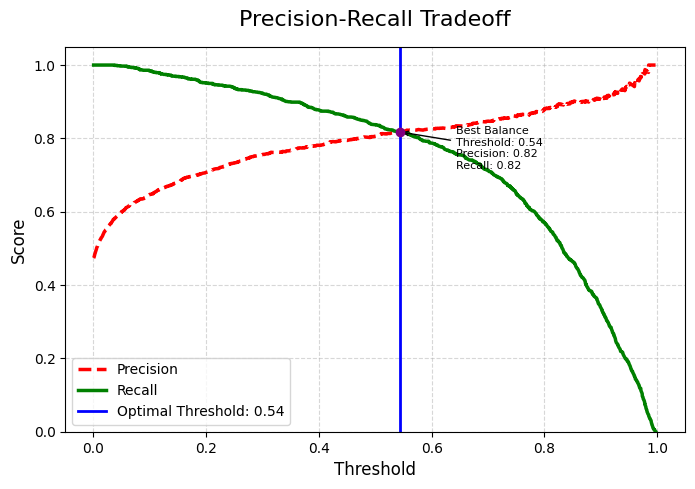

In [177]:
plot_precision_recall_tradeoff(precision, recall, thresholds)

# Deciphering the Confusion Matrix  

## Beyond Accuracy: Seeing the Full Picture  
Accuracy alone doesn’t reveal where a model goes wrong. The confusion matrix shows not just overall performance but the exact nature of successes and mistakes.  

---

### 🟩 True Negatives (Top-Left)  
Correctly identified **non-subscribers** → prevents wasted effort on uninterested clients.  

### 🟥 False Positives (Top-Right)  
Predicted as subscribers but **actually not interested** → wasted calls, emails, and resources.  

### 🟥 False Negatives (Bottom-Left)  
Real subscribers the model **failed to detect** → costly missed opportunities.  

### 🟩 True Positives (Bottom-Right)  
Correctly predicted **subscribers** → the key wins that boost campaign success.  

---

## Why It Matters  
The matrix reveals:  
- **Precision** → how accurate the “Yes” predictions are  
- **Recall** → how many true subscribers we capture  
- **Tradeoffs** → whether minimizing false positives or false negatives matters more  

👉 An ideal matrix isn’t always perfectly diagonal — the “best” depends on whether the business values avoiding wasted outreach or maximizing captured opportunities.  


In [178]:
xgb_predictions = xgb_model.predict(x_test_prepared)

In [179]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test_input, predictions):
    conf_matrix = confusion_matrix(y_test_input, predictions)
    f, ax = plt.subplots(figsize=(8,5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.5, ax=ax, cmap="Blues")
    plt.title("XGBoost Confusion Matrix", fontsize=20)
    plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
    ax.set_xticklabels(['Predicted No', 'Predicted Yes'], fontsize=16, rotation=0)
    ax.set_yticklabels(['Actual No', 'Actual Yes'], fontsize=16, rotation=0)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()



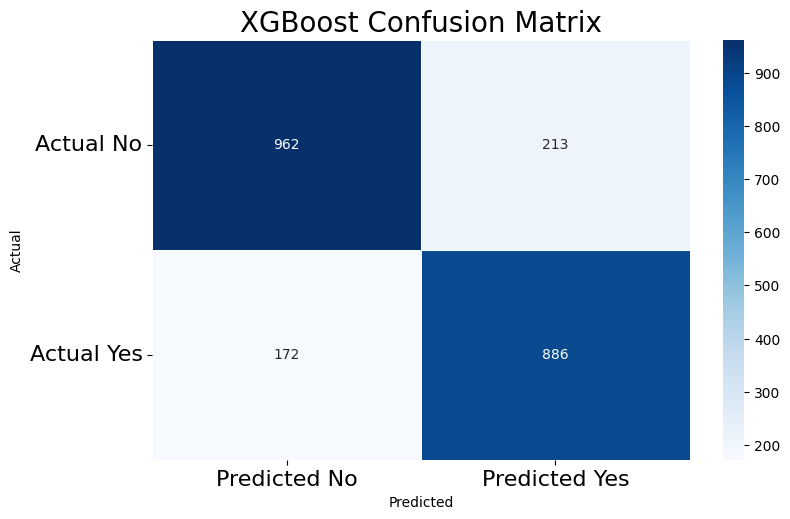

In [180]:
plot_confusion_matrix(y_test_prepared, xgb_predictions)

### ROC Curve (Receiver Operating Characteristic)

The ROC curve evaluates how well a classifier distinguishes between clients who subscribe to a term deposit (positive class) and those who do not (negative class).  
- **X-axis:** False Positive Rate (1 - Specificity)  
- **Y-axis:** True Positive Rate (Sensitivity/Recall)  

As the threshold shifts, the ROC curve plots different trade-offs between correctly identifying positives and incorrectly classifying negatives. A model that performs well will have a curve that rises quickly toward the **top-left corner**, indicating strong separation between the two classes. A random model, by contrast, would lie close to the diagonal line from bottom-left to top-right.



In [181]:
from sklearn.metrics import roc_curve, roc_auc_score

In [182]:
def calculate_auc_scores(classifiers_dict, X_test, y_test):
    """
    Calculates ROC AUC scores for multiple classifiers and returns them in a pandas DataFrame.

    Args:
        classifiers_dict (dict): A dictionary where keys are classifier names
                                 and values are the trained classifier objects.
        X_test (pd.DataFrame): The feature set for testing.
        y_test (pd.Series): The true labels for the test set.

    Returns:
        pd.DataFrame: A DataFrame containing the classifier names and their
                      respective ROC AUC scores, sorted in descending order.
    """
    auc_scores = {}
    
    # Iterate through the provided classifiers
    for name, classifier in classifiers_dict.items():
        # Get predicted probabilities for the positive class
        y_pred_proba = classifier.predict_proba(X_test)[:, 1]
        
        # Calculate the AUC score
        auc = roc_auc_score(y_test, y_pred_proba)
        
        # Store the result
        auc_scores[name] = auc
    
    # Create and sort the DataFrame
    auc_df = pd.DataFrame({
        "Classifier": list(auc_scores.keys()),
        "ROC_AUC": list(auc_scores.values())
    }).sort_values(by="ROC_AUC", ascending=False).reset_index(drop=True)
    
    return auc_df

In [183]:
auc_df = calculate_auc_scores(best_models, x_test_prepared, y_test_prepared)
auc_df  

,Classifier,ROC_AUC
0,XGBoost,0.904059
1,Gradient Boosting,0.903268
2,Logistic Regression,0.886184
3,Linear SVM,0.885603
4,Neural Net,0.868717
5,Decision Tree,0.861666
6,Nearest Neighbors,0.853965
7,Naive Bayes,0.783873


In [184]:
def plot_multiple_roc_curves(classifiers_dict, X_test, y_test):
    """
    Plots the ROC curves for multiple classifiers on a single graph.

    Args:
        classifiers_dict (dict): A dictionary where keys are classifier names
                                 and values are the trained classifier objects.
        X_test (pd.DataFrame): The feature set for testing.
        y_test (pd.Series): The true labels for the test set.
    """
    plt.figure(figsize=(8, 5))
    plt.title('ROC Curves for Multiple Classifiers', fontsize=18)
    
    # Plot the random classifier baseline
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)')
    
    # Iterate through the provided classifiers
    for name, classifier in classifiers_dict.items():
        # Get predicted probabilities for the positive class
        y_pred_proba = classifier.predict_proba(X_test)[:, 1]
        
        # Calculate FPR, TPR, and AUC
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        
        # Plot the ROC curve for the current classifier
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.4f})')
        
    plt.xlabel('False Positive Rate (FPR)', fontsize=14)
    plt.ylabel('True Positive Rate (TPR)', fontsize=14)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(True)
    plt.show()

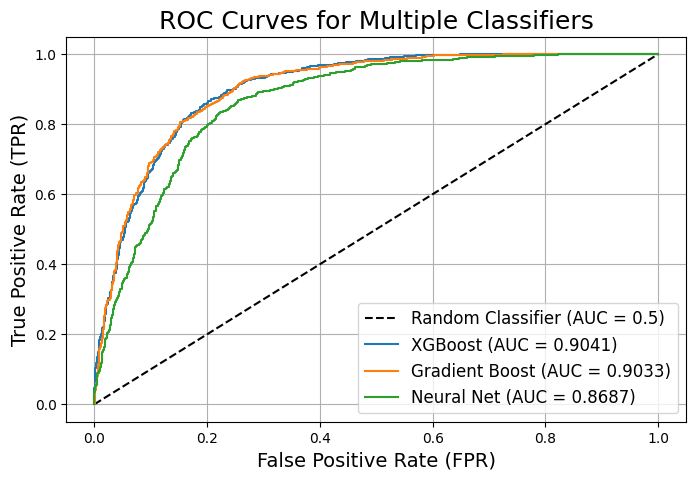

In [185]:
top_3_models = {'XGBoost': best_models['XGBoost'], 'Gradient Boost': best_models['Gradient Boosting'], 'Neural Net': best_models['Neural Net']}

plot_multiple_roc_curves(top_3_models, x_test_prepared, y_test_prepared)

In [186]:
from sklearn.ensemble import VotingClassifier

voting_classifier = VotingClassifier(
    estimators=[  
        ("XGBoost", xgb_model),
        ("Gradient Boost", grad_model),  
        ("Neural Net", neural_model)  
    ],
    voting='soft'
)

voting_classifier.fit(x_train_prepared, y_train_prepared)  

c:\Users\Shervin Zare\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning:

[00:29:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.




,"estimators estimators: list of (str, estimator) tuplesInvoking the ``fit`` method on the ``VotingClassifier`` will fit clonesof those original estimators that will be stored in the class attribute``self.estimators_``. An estimator can be set to ``'drop'`` using:meth:`set_params`... versionchanged:: 0.21 ``'drop'`` is accepted. Using None was deprecated in 0.22 and support was removed in 0.24.","[('XGBoost', ...), ('Gradient Boost', ...), ...]"
,"voting voting: {'hard', 'soft'}, default='hard'If 'hard', uses predicted class labels for majority rule voting.Else if 'soft', predicts the class label based on the argmax ofthe sums of the predicted probabilities, which is recommended foran ensemble of well-calibrated classifiers.",'soft'
,"weights weights: array-like of shape (n_classifiers,), default=NoneSequence of weights (`float` or `int`) to weight the occurrences ofpredicted class labels (`hard` voting) or class probabilitiesbefore averaging (`soft` voting). Uses uniform weights if `None`.",None
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for ``fit``.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionadded:: 0.18",None
,"flatten_transform flatten_transform: bool, default=TrueAffects shape of transform output only when voting='soft'If voting='soft' and flatten_transform=True, transform method returnsmatrix with shape (n_samples, n_classifiers * n_classes). Ifflatten_transform=False, it returns(n_classifiers, n_samples, n_classes).",True
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting will be printed as itis completed... versionadded:: 0.23",False
,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None


In [187]:
def evaluate_models_accuracy(*models, X_train, y_train, X_test, y_test):
    """
    Evaluate multiple models and return accuracy scores in a DataFrame.
    
    Parameters:
    *models: Variable number of model objects
    X_train: Training features
    y_train: Training labels
    X_test: Test features
    y_test: Test labels
    
    Returns:
    pd.DataFrame: DataFrame with accuracy scores for each model
    """
    
    results = []
    
    for clf in models:
        clf.fit(X_train, y_train)
        predict = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predict)
        
        results.append({
            'Classifier': clf.__class__.__name__,
            'Accuracy': accuracy
        })
    
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('Accuracy', ascending=False)
    
    return results_df

In [188]:
prediction_results = evaluate_models_accuracy(
    xgb_model, grad_model, neural_model, voting_classifier,
    X_train=x_train_prepared, 
    y_train=y_train_prepared,  
    X_test=x_test_prepared, 
    y_test=y_test_prepared    
)

prediction_results = prediction_results.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
prediction_results = prediction_results[prediction_results['Classifier'] != 'VotingClassifier']
prediction_results

c:\Users\Shervin Zare\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning:

[00:30:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\Shervin Zare\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning:

[00:30:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.




,Classifier,Accuracy
0,XGBClassifier,0.827586
2,GradientBoostingClassifier,0.824004
3,MLPClassifier,0.799373


## Model Export & Prediction Generation (Deployment Step)

In this step, we prepare the final trained model for deployment by packaging **both preprocessing and the classifier** into a single pipeline. This ensures that any new data passed into the model during production undergoes the exact same transformations used during training, eliminating data leakage and consistency issues.

We then export:
1. The **trained end-to-end pipeline** for reuse in production environments (e.g., APIs, dashboards, or cloud deployment).
2. The **model predictions** and **probability scores**, which can be used by business stakeholders to rank customers and support data-driven decision-making.

In [189]:
from sklearn.pipeline import Pipeline
import joblib

final_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", xgb_model)
])

final_pipeline.fit(x_train, y_train_prepared)

joblib.dump(final_pipeline, "bank_marketing_xgboost_pipeline.joblib")

c:\Users\Shervin Zare\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning:

[00:30:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.




['bank_marketing_xgboost_pipeline.joblib']

In [190]:
preds = final_pipeline.predict(x_test)

predictions_df = pd.DataFrame({
    "prediction": preds
})

predictions_df.to_csv("bank_campaign_predictions.csv", index=False)

# Probability scores for ranking customers
probs = final_pipeline.predict_proba(x_test)[:, 1]

prob_df = pd.DataFrame({
    "subscription_probability": probs
})

prob_df.to_csv("bank_campaign_probabilities.csv", index=False)

# 🏆 Final Model: XGBoost Classifier

After evaluating multiple machine learning models, the **XGBoost Classifier** was selected as the best-performing approach for predicting term deposit subscription.

## 🎯 Performance Summary
- **Accuracy:** 82.76%  
- **ROC AUC:** 90.41%  
- **Recall:** 83.74%  

XGBoost achieved the strongest overall performance, particularly in probability ranking (ROC AUC), making it well-suited for targeted marketing use cases.

## 🚀 Business Value
The model enables the bank to:
- Target high-probability clients more effectively  
- Improve conversion rates while reducing campaign costs  
- Support personalized outreach based on predicted likelihood of subscription  

## 📦 Deployment & Exports
To ensure real-world usability, the final solution was made deployment-ready:
- **`bank_marketing_xgboost_pipeline.joblib`** — a single pipeline containing preprocessing and the trained XGBoost model for consistent inference on new data  
- **`bank_campaign_predictions.csv`** — final class predictions  
- **`bank_campaign_probabilities.csv`** — probability scores for ranking customers  

## 📈 Key Recommendations
- Use **probability-based scoring** to prioritize outreach rather than binary predictions  
- Focus on **call quality over volume**, as longer engagement strongly correlates with subscription  
- Refine targeting using demographic signals such as education and marital status  

**Final takeaway:** combining a high-performing XGBoost model with a deployable pipeline allows the bank to shift from broad campaigns to data-driven, precision targeting.
